<a href="https://colab.research.google.com/github/LeController/EEG-Group7/blob/main/eeg_with_ICA_to__specgram_2ch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 4.3 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

#import torchaudio
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

In [ ]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = '/datasets'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        # self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                count += 1

        raw = mne.io.concatenate_raws(raws)
        eegbci.standardize(raw)
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        
        print("Done.")
        return self.raw
    def filter(self, freq):
        raw = self.raw
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        return  raw
    def raw_ica(self):
      raw = self.raw
      ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
      ica.fit(raw)
      ica.exclude = [1, 2]  # details on how we picked these are omitted here
      ica.plot_properties(raw, picks=ica.exclude)
      ica.apply(raw)
      print('ICA DONE ????')
      return  raw
        
    def get_events(self):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')
        tmin = 0
        tmax = 4
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True)
        return epochs
    
    def create_epochs(self):
        print(">>> Create Epochs.")
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        return events , event_id
        
        print("Done.")
    
    def get_X_y(self):
        if self.epochs is None:
            events , event_id=self.create_epochs()
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
def do_plot(train_losses):
    plt.figure(figsize=(10,10))
    clear_output(wait=True)
    #plt.plot(train_acc, label='train_acc')
    plt.plot(train_losses, label='train_losses')
    plt.title('loss {}'.format(iter))
    plt.legend()
    plt.show()


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

>>> Extract all subjects from: datasets.
Loading file #1/60: S001R03.edf
Loading file #2/60: S001R04.edf
Loading file #3/60: S001R07.edf
Loading file #4/60: S001R08.edf
Loading file #5/60: S001R11.edf
Loading file #6/60: S001R12.edf
Loading file #7/60: S002R03.edf
Loading file #8/60: S002R04.edf
Loading file #9/60: S002R07.edf
Loading file #10/60: S002R08.edf
Loading file #11/60: S002R11.edf
Loading file #12/60: S002R12.edf
Loading file #13/60: S003R03.edf
Loading file #14/60: S003R04.edf
Loading file #15/60: S003R07.edf
Loading file #16/60: S003R08.edf
Loading file #17/60: S003R11.edf
Loading file #18/60: S003R12.edf
Loading file #19/60: S004R03.edf
Loading file #20/60: S004R04.edf
Loading file #21/60: S004R07.edf
Loading file #22/60: S004R08.edf
Loading file #23/60: S004R11.edf
Loading file #24/60: S004R12.edf
Loading file #25/60: S005R03.edf
Loading file #26/60: S005R04.edf
Loading file #27/60: S005R07.edf
Loading file #28/60: S005R08.edf
Loading file #29/60: S005R11.edf
Loading fil

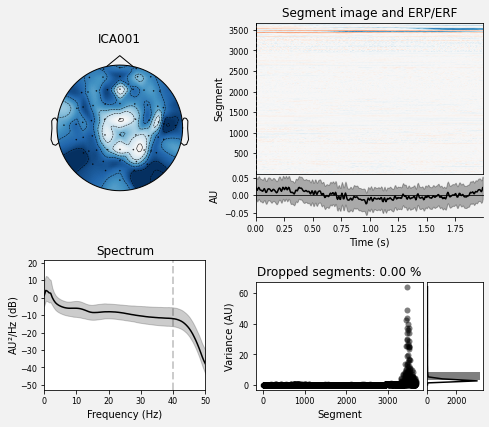

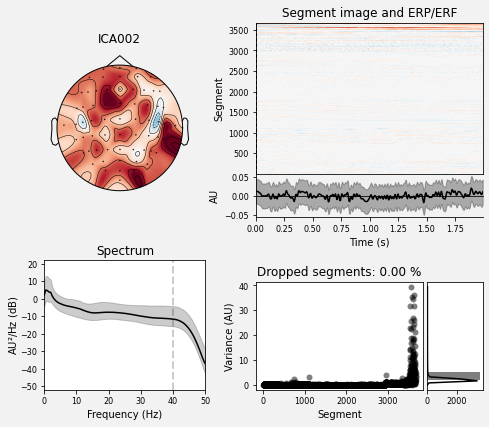

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
ICA DONE ????
>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Loading data for 900 events and 641 original time points ...
0 bad epochs dropped


(array([[    672,       0,       1],
        [   2000,       0,       0],
        [   3328,       0,       0],
        ...,
        [1183280,       0,       1],
        [1184592,       0,       0],
        [1185904,       0,       0]]),
 {'T1': 0, 'T2': 1})

In [ ]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
subjects = [i for i in range(1, 11)]
#subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
# apply filter
freq = (0.05, 40.)
raw=eeg.filter(freq=freq)
raw=eeg.raw_ica()
eeg.create_epochs()

Using matplotlib as 2D backend.


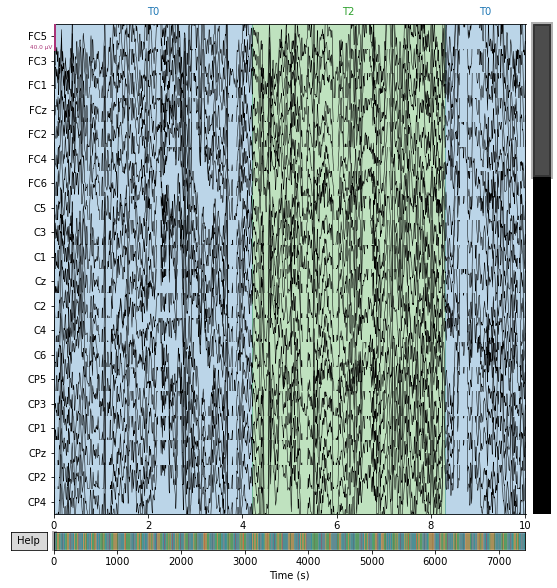

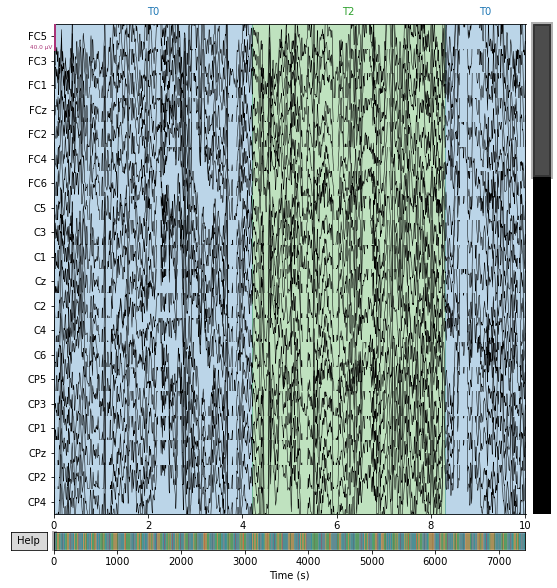

In [ ]:
raw.plot()

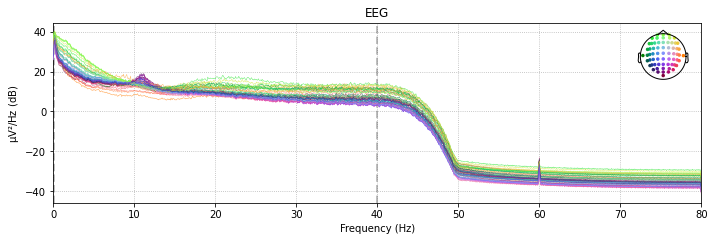

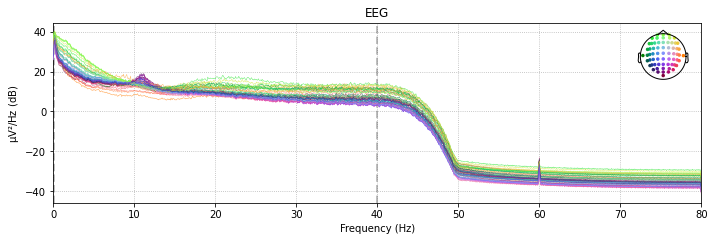

In [ ]:
raw.plot_psd()

In [ ]:
print(eeg.raw.ch_names)
X, y= eeg.get_X_y()
#events , event_id =eeg.get_events()

X2 = X[:, 7, :] 
print(X2.shape)

X3= X[:,  13, :]
print(X3.shape)

X4 = np.stack((X2,X3),1)
print(X4.shape)
X =X4

print(X.shape, y.shape)

['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
(900, 641)
(900, 641)
(900, 2, 641)
(900, 2, 641) (900,)


1


IndexError: index 2 is out of bounds for axis 0 with size 2

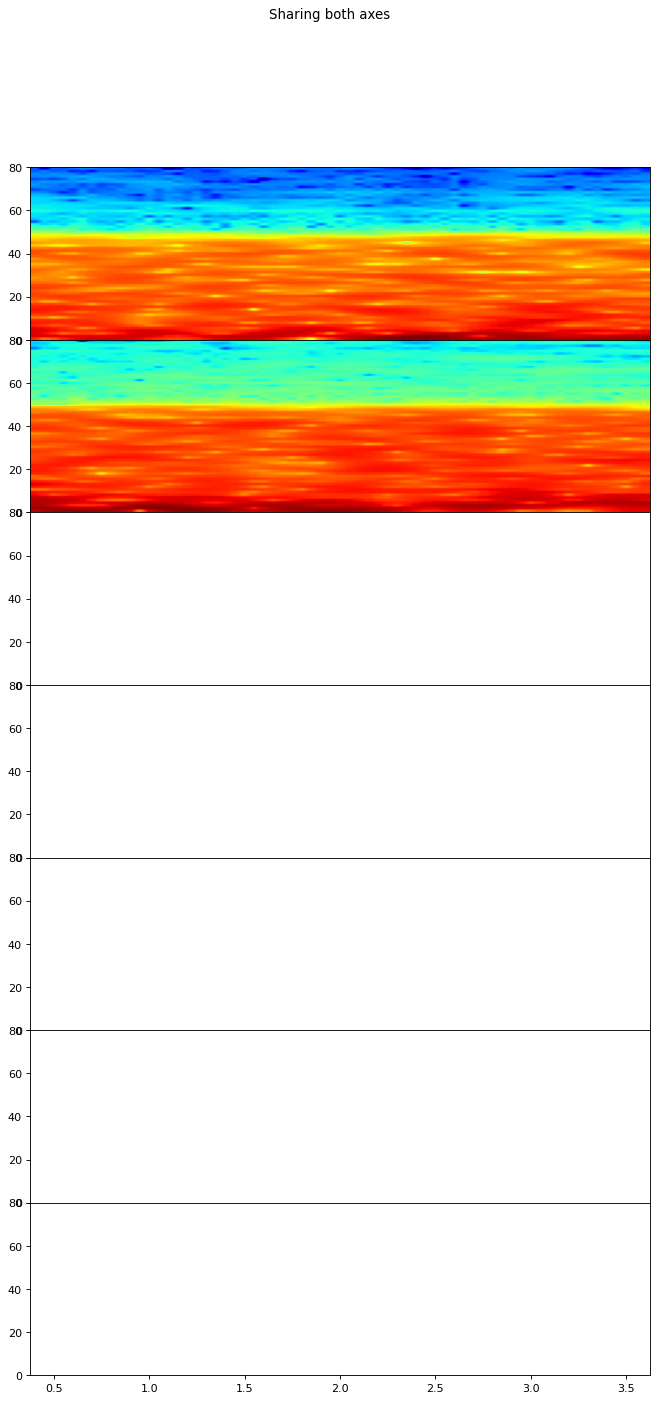

In [ ]:
for i in range (X.shape[0]):
    print(i+1)
    fig = plt.figure(figsize=(10, 20),dpi=80)
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.suptitle('Sharing both axes')
    ax1=axs[0].specgram(X[i][0], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax2=axs[1].specgram(X[i][1], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    #ax3=axs[2].specgram(X[i][2], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    #ax4=axs[3].specgram(X[i][3], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    #ax5=axs[4].specgram(X[i][4], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    #ax6=axs[5].specgram(X[i][5], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    #ax7=axs[6].specgram(X[i][6], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    #ax7=axs[6].specgram(X[i][6], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    axs[0].set_ylim(bottom=0, top=50)
    axs[0].axis('off')
    axs[1].axis('off')
    #axs[2].axis('off')
    axs[3].axis('off')
    axs[4].axis('off')
    axs[5].axis('off')
    axs[6].axis('off')
    fig.savefig('EEG_img_2CH/{}.png'.format(i), bbox_inches='tight')
print('Done !!!')

TypeError: ignored

<Figure size 800x1600 with 0 Axes>